# lab6 对ESI数据的深度学习&聚类分析
主要完成了：
- 利用深度学习方法，对各学科做一个排名模型，能够较好的预测出排名位置，并且利用MSE，MAPE等指标来进行评价模型的优劣。
- 对ESI的数据进行聚类，发现与华师大类似的学校有哪些

## 0. 导入库函数与数据预处理

In [1]:
# 1. 导入所需库
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings('ignore')

# 展示高清图 
from matplotlib_inline import backend_inline 
backend_inline.set_matplotlib_formats('svg') 

print("所有库已成功导入！")

所有库已成功导入！


In [2]:
# 加载数据
df = pd.read_csv('alldata.csv')

# 查看数据基本信息
print("数据集基本信息：")
print(f"数据形状: {df.shape}")
print(f"学科数量: {df['subject_name'].nunique()}")

# 缺失值处理
print(f"缺失值统计：",df.isnull().sum())
df = df.dropna()
print("\n缺失值处理后数据形状: ", df.shape)

数据集基本信息：
数据形状: (34121, 9)
学科数量: 22
缺失值统计： id                             0
subject_name                   0
institution_name               0
country_region              3161
world_rank                     0
web_of_science_documents       0
cites                          0
cites_per_paper                0
top_papers                     0
dtype: int64

缺失值处理后数据形状:  (30960, 9)


## 1 深度学习预测排名

### 1.1 深度学习数据准备
设置随机种子、设置数值特征和类别特征、数值标准化与缩放、数据集/验证集/测试集划分、自定义数据集

In [3]:
# 固定随机种子以便复现
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 目标变量
raw_y = df['world_rank'].values.astype(float)

# 数值特征
num_features = ["web_of_science_documents", "cites", "cites_per_paper", "top_papers"]
X_num = df[num_features].values.astype(float)

# 类别特征
cat_features = ["subject_name", "institution_name", "country_region"]

# 类别编码
encoders = {}
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
X_cat = df[cat_features].values.astype(int)

#划分数据集：60% 训练 / 20% 验证 / 20% 测试
Xn_train, Xn_temp, Xc_train, Xc_temp, y_train, y_temp = train_test_split(
    X_num, X_cat, raw_y, test_size=0.4, random_state=seed   # 默认打乱数据
)
Xn_val, Xn_test, Xc_val, Xc_test, y_val, y_test = train_test_split(
    Xn_temp, Xc_temp, y_temp, test_size=0.5, random_state=seed
)


# 数值标准化
scaler_X = StandardScaler()
Xn_train_scaled = scaler_X.fit_transform(Xn_train) # 只有训练集用于拟合标准化器
Xn_val_scaled = scaler_X.transform(Xn_val)
Xn_test_scaled = scaler_X.transform(Xn_test)

# 目标缩放：使用 MinMax 把排名缩放到 [0,1]
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)) # 只有训练集用于拟合缩放器
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

使用设备: cpu


### 1.2 数据集及模型定义
定义数据集、模型并创建实例

In [4]:
# 自定义 Dataset
class ESIDataset(Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
        if self.y.ndim == 1:
            self.y = self.y.unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]

train_dataset = ESIDataset(Xn_train_scaled, Xc_train, y_train_scaled) 
val_dataset = ESIDataset(Xn_val_scaled, Xc_val, y_val_scaled)
test_dataset = ESIDataset(Xn_test_scaled, Xc_test, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # shuffle=True 先洗牌再分批
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

# 模型定义：数值输入 + 类别嵌入 -> MLP
class RankPredictor(nn.Module):
    def __init__(self, num_input_dim, cat_dims, hidden_dim=128, dropout=0.2):
        super().__init__()
        # 嵌入层
        self.emb_layers = nn.ModuleList() # 创建模块列表用于存储嵌入层
        for cat_dim in cat_dims:
            emb_dim = min(50, max(4, cat_dim // 2))
            self.emb_layers.append(nn.Embedding(cat_dim, emb_dim))
        emb_total = sum([emb.embedding_dim for emb in self.emb_layers]) # 嵌入层总维度
        input_dim = num_input_dim + emb_total # 总输入维度

        # 网络结构
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # 第一层
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2), # 第二层
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 2, 1), # 输出层
            nn.Sigmoid()
        )

    def forward(self, x_num, x_cat):
        emb = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.emb_layers)]
        x = torch.cat([x_num] + emb, dim=1)
        return self.net(x)

cat_dims = [int(df[col].nunique()) for col in cat_features]
model = RankPredictor(num_input_dim=len(num_features), cat_dims=cat_dims).to(device)

### 1.3 训练模型

In [5]:
# 损失函数
criterion = nn.MSELoss()
# 优化算法
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# 学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

# 开始训练
n_epochs_pretrain = 100
early_stop_patience = 6
best_val_loss = float('inf')
best_epoch = 0
train_losses = []
val_losses = []

for epoch in range(1, n_epochs_pretrain + 1):
    model.train() # 训练模式
    running_loss = 0.0
    for Xn_batch, Xc_batch, yb in train_loader:
        # 数据搬到设备
        Xn_batch = Xn_batch.to(device)
        Xc_batch = Xc_batch.to(device)
        yb = yb.to(device)
        # 前向传播
        pred = model(Xn_batch, Xc_batch)
        loss = criterion(pred, yb)
        # 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 累积损失
        running_loss += loss.item() * Xn_batch.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset) # 平均训练损失

    # 验证
    model.eval() # 评估模式
    val_running = 0.0
    with torch.no_grad():
        for Xn_batch, Xc_batch, yb in val_loader:
            Xn_batch = Xn_batch.to(device)
            Xc_batch = Xc_batch.to(device)
            yb = yb.to(device)
            pred = model(Xn_batch, Xc_batch)
            val_running += criterion(pred, yb).item() * Xn_batch.size(0)       
    epoch_val_loss = val_running / len(val_loader.dataset) # 平均验证损失

    # 记录损失
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    # 学习率调度器更新
    scheduler.step(epoch_val_loss)

    # 保存最佳模型
    if epoch_val_loss < best_val_loss - 1e-6:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch}/{n_epochs_pretrain}  Train Loss: {epoch_train_loss:.6f}  Val Loss: {epoch_val_loss:.6f}")

    # 早停检查
    if epoch - best_epoch >= early_stop_patience:
        print(f"早停触发，最佳 epoch: {best_epoch}")
        break

print(f"训练结束，最佳验证 loss: {best_val_loss:.6f} (epoch {best_epoch})")


Epoch 1/100  Train Loss: 0.015620  Val Loss: 0.006264
Epoch 2/100  Train Loss: 0.005571  Val Loss: 0.004286
Epoch 3/100  Train Loss: 0.004070  Val Loss: 0.003673
Epoch 4/100  Train Loss: 0.003301  Val Loss: 0.003026
Epoch 5/100  Train Loss: 0.002823  Val Loss: 0.003121
Epoch 6/100  Train Loss: 0.002522  Val Loss: 0.003140
Epoch 7/100  Train Loss: 0.002170  Val Loss: 0.002997
Epoch 8/100  Train Loss: 0.002029  Val Loss: 0.003104
Epoch 9/100  Train Loss: 0.001863  Val Loss: 0.002777
Epoch 10/100  Train Loss: 0.001821  Val Loss: 0.002799
Epoch 11/100  Train Loss: 0.001678  Val Loss: 0.002633
Epoch 12/100  Train Loss: 0.001601  Val Loss: 0.002578
Epoch 13/100  Train Loss: 0.001565  Val Loss: 0.002612
Epoch 14/100  Train Loss: 0.001452  Val Loss: 0.002534
Epoch 15/100  Train Loss: 0.001369  Val Loss: 0.002466
Epoch 16/100  Train Loss: 0.001387  Val Loss: 0.002376
Epoch 17/100  Train Loss: 0.001322  Val Loss: 0.002463
Epoch 18/100  Train Loss: 0.001262  Val Loss: 0.002316
Epoch 19/100  Train

### 1.4 评估模型
在测试集上对模型进行测试，将测试结果可视化，计算MSE、RMSE、MAPE等评估指标

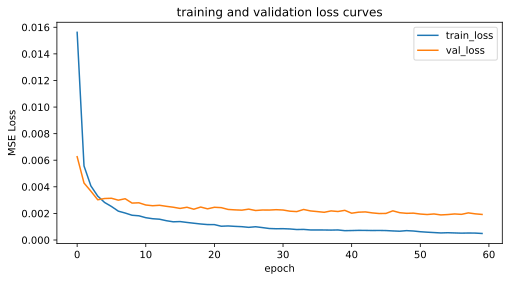

全局模型测试评估: MSE=94318.2500, RMSE=307.1128, MAPE=0.1959


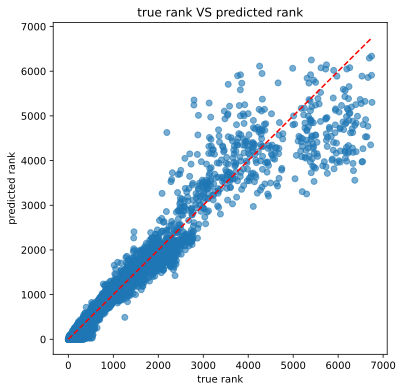

全局模型预测示例（前10条）:
真实: 69  预测: 1.0
真实: 1656  预测: 1772.4
真实: 1369  预测: 1501.3
真实: 506  预测: 544.9
真实: 748  预测: 848.3
真实: 232  预测: 310.1
真实: 253  预测: 192.7
真实: 1357  预测: 1538.1
真实: 224  预测: 373.2
真实: 85  预测: 84.8


In [6]:
# 恢复并评估模型
model.load_state_dict(best_state)
model.to(device) 

plt.figure(figsize=(8,4))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

# 测试集评估
model.eval()
preds = []
trues = []
with torch.no_grad():
    for Xn_batch, Xc_batch, yb in test_loader: # 批量循环处理
        # 数据移动
        Xn_batch = Xn_batch.to(device)
        Xc_batch = Xc_batch.to(device)
        out = model(Xn_batch, Xc_batch).cpu().numpy()
        # 结果收集
        preds.append(out) # 预测结果
        trues.append(yb.cpu().numpy()) # 真实结果

# 合并所有批次结果
preds = np.vstack(preds)
trues = np.vstack(trues)

# 反缩放回原始排名
preds_orig = y_scaler.inverse_transform(preds)
trues_orig = y_scaler.inverse_transform(trues)

# 计算评估指标
mse_global = mean_squared_error(trues_orig, preds_orig)
rmse_global = np.sqrt(mse_global)
mape_global = mean_absolute_percentage_error(trues_orig, preds_orig)
print(f"全局模型测试评估: MSE={mse_global:.4f}, RMSE={rmse_global:.4f}, MAPE={mape_global:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(trues_orig, preds_orig, alpha=0.6)
plt.plot([trues_orig.min(), trues_orig.max()], [trues_orig.min(), trues_orig.max()], 'r--')
plt.xlabel('true rank')
plt.ylabel('predicted rank')
plt.title('true rank VS predicted rank')
plt.show()

print('全局模型预测示例（前10条）:')
for i in range(min(10, len(preds_orig))):
    print(f"真实: {int(trues_orig[i,0])}  预测: {preds_orig[i,0]:.1f}")


### 1.5 按学科微调模型
由于之前是所有学科一起进行训练的，可能结果会收到不同学科数据的影响，因此再按照分学科对模型进行微调
微调模型的流程和前面训练模型的流程类似，不同在于epoch数较少（避免干扰以前已学习的特征），学习率较小（保持原有学习特征 更精细）


微调学科 '0' (样本数: 1331)
  微调早停，epoch: 4
  微调后评估: MSE=7326.5625, RMSE=85.5953, MAPE=0.1120

微调学科 '1' (样本数: 1601)
  微调早停，epoch: 6
  微调后评估: MSE=6790.0562, RMSE=82.4018, MAPE=0.1291

微调学科 '2' (样本数: 2094)
  微调早停，epoch: 8
  微调后评估: MSE=5684.3745, RMSE=75.3948, MAPE=0.1311

微调学科 '3' (样本数: 4459)
  微调后评估: MSE=221038.1406, RMSE=470.1469, MAPE=0.1479

微调学科 '4' (样本数: 839)
  微调后评估: MSE=6110.5601, RMSE=78.1701, MAPE=0.2010

微调学科 '5' (样本数: 537)
  微调后评估: MSE=2090.3472, RMSE=45.7203, MAPE=0.1559

微调学科 '6' (样本数: 2673)
  微调早停，epoch: 14
  微调后评估: MSE=18215.9961, RMSE=134.9666, MAPE=0.1328

微调学科 '7' (样本数: 1988)
  微调后评估: MSE=8305.6943, RMSE=91.1356, MAPE=0.1299

微调学科 '8' (样本数: 1142)
  微调早停，epoch: 4
  微调后评估: MSE=3463.0818, RMSE=58.8480, MAPE=0.1957

微调学科 '9' (样本数: 1145)
  微调早停，epoch: 3
  微调后评估: MSE=2492.5376, RMSE=49.9253, MAPE=0.1067

微调学科 '10' (样本数: 1550)
  微调早停，epoch: 10
  微调后评估: MSE=4937.9731, RMSE=70.2707, MAPE=0.1548

微调学科 '11' (样本数: 385)
  微调后评估: MSE=3122.0251, RMSE=55.8751, MAPE=0.3009

微调学科 '12' (样本数: 7

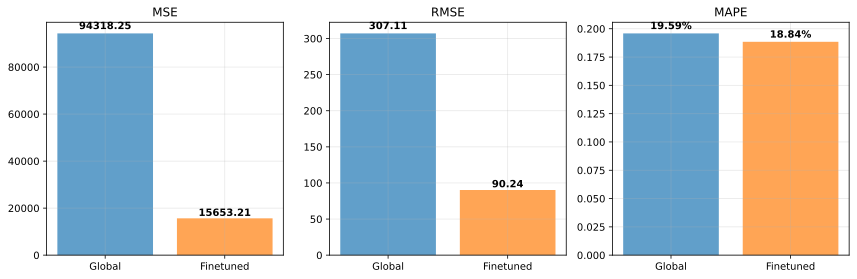


改进统计:
MSE改进: 83.40%
RMSE改进: 70.62%
MAPE改进: 3.81%


In [7]:
# 按学科分组数据
df.reset_index(drop=True, inplace=True)
subject_groups = df.groupby('subject_name')

# 微调设置
finetune_epochs = 20  # 微调 epoch 数（少量）
finetune_lr = 1e-4  # 微调学习率（较小）
finetune_patience = 5  # 早停 patience

# 存储每学科微调结果
finetune_results = {}

X_num_scaled_full = scaler_X.transform(X_num)  # 使用训练集的标准化器转换所有数据
y_scaled_full = y_scaler.transform(raw_y.reshape(-1, 1))  # 使用训练集的缩放器转换所有目标

for subject, group in subject_groups:
    n_samples = len(group)

    print(f"\n微调学科 '{subject}' (样本数: {n_samples})")

    # 提取该学科的数据 - 使用完整的标准化数据
    indices = list(group.index)  # 转换为列表
    Xn_sub = X_num_scaled_full[indices]  # 使用完整的标准化数值特征
    Xc_sub = X_cat[indices]  # 分类特征不需要标准化
    y_sub = y_scaled_full[indices]  # 使用完整缩放后的目标

    # 划分该学科的训练/验证/测试（60/20/20）
    Xn_sub_train, Xn_sub_temp, Xc_sub_train, Xc_sub_temp, y_sub_train, y_sub_temp = train_test_split(
        Xn_sub, Xc_sub, y_sub, test_size=0.4, random_state=seed
    )
    Xn_sub_val, Xn_sub_test, Xc_sub_val, Xc_sub_test, y_sub_val, y_sub_test = train_test_split(
        Xn_sub_temp, Xc_sub_temp, y_sub_temp, test_size=0.5, random_state=seed
    )

    # 创建该学科的 DataLoader
    sub_train_dataset = ESIDataset(Xn_sub_train, Xc_sub_train, y_sub_train)
    sub_val_dataset = ESIDataset(Xn_sub_val, Xc_sub_val, y_sub_val)
    sub_test_dataset = ESIDataset(Xn_sub_test, Xc_sub_test, y_sub_test)
    sub_train_loader = DataLoader(sub_train_dataset, batch_size=32, shuffle=True)  # 小 batch
    sub_val_loader = DataLoader(sub_val_dataset, batch_size=64)
    sub_test_loader = DataLoader(sub_test_dataset, batch_size=64)

    # 加载全局模型状态作为初始化
    model.load_state_dict(best_state)
    model.to(device)

    # 微调优化器（较小 lr）
    optimizer_finetune = torch.optim.Adam(model.parameters(), lr=finetune_lr)

    # 微调训练（初始化 best_sub_state）
    best_sub_val_loss = float('inf')
    best_sub_epoch = 0
    best_sub_state = best_state.copy()  # 初始化为微调前的最佳
    sub_train_losses = []
    sub_val_losses = []

    for epoch in range(1, finetune_epochs + 1):
        # 训练
        model.train()
        running_loss = 0.0
        for Xn_batch, Xc_batch, yb in sub_train_loader:
            # 移动数据
            Xn_batch = Xn_batch.to(device)
            Xc_batch = Xc_batch.to(device)
            yb = yb.to(device)
            # 前向传播
            pred = model(Xn_batch, Xc_batch)
            loss = criterion(pred, yb)
            # 反向传播与优化
            optimizer_finetune.zero_grad()
            loss.backward()
            optimizer_finetune.step()
            running_loss += loss.item() * Xn_batch.size(0)
        # 计算平均训练损失
        epoch_train_loss = running_loss / len(sub_train_loader.dataset)

        # 验证
        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for Xn_batch, Xc_batch, yb in sub_val_loader:
                Xn_batch = Xn_batch.to(device)
                Xc_batch = Xc_batch.to(device)
                yb = yb.to(device)
                pred = model(Xn_batch, Xc_batch)
                val_running += criterion(pred, yb).item() * Xn_batch.size(0)
        epoch_val_loss = val_running / len(sub_val_loader.dataset)

        sub_train_losses.append(epoch_train_loss)
        sub_val_losses.append(epoch_val_loss)

        if epoch_val_loss < best_sub_val_loss - 1e-6:
            best_sub_val_loss = epoch_val_loss
            best_sub_epoch = epoch
            best_sub_state = {k: v.cpu() for k, v in model.state_dict().items()}

        if epoch - best_sub_epoch >= finetune_patience:
            print(f"  微调早停，epoch: {best_sub_epoch}")
            break

    # 加载最佳微调模型并评估
    model.load_state_dict(best_sub_state)
    model.eval()
    preds_sub = []
    trues_sub = []
    with torch.no_grad():
        for Xn_batch, Xc_batch, yb in sub_test_loader:
            Xn_batch = Xn_batch.to(device)
            Xc_batch = Xc_batch.to(device)
            out = model(Xn_batch, Xc_batch).cpu().numpy()
            preds_sub.append(out)
            trues_sub.append(yb.cpu().numpy())

    preds_sub = np.vstack(preds_sub)
    trues_sub = np.vstack(trues_sub)

    preds_sub_orig = y_scaler.inverse_transform(preds_sub)
    trues_sub_orig = y_scaler.inverse_transform(trues_sub)

    mse_sub = mean_squared_error(trues_sub_orig, preds_sub_orig)
    rmse_sub = np.sqrt(mse_sub)
    mape_sub = mean_absolute_percentage_error(trues_sub_orig, preds_sub_orig)

    finetune_results[subject] = {
        'n_samples': n_samples,
        'mse': mse_sub,
        'rmse': rmse_sub,
        'mape': mape_sub,
        'best_epoch': best_sub_epoch
    }

    print(f"  微调后评估: MSE={mse_sub:.4f}, RMSE={rmse_sub:.4f}, MAPE={mape_sub:.4f}")

# 与微调前模型对比结果
print(f"全局模型 (所有学科一起训练): MSE={mse_global:.4f}, RMSE={rmse_global:.4f}, MAPE={mape_global:.4f}")
print("\n微调后各学科结果:")
for subject, res in finetune_results.items():
    print(f"学科 '{subject}' (样本数: {res['n_samples']}): MSE={res['mse']:.4f}, RMSE={res['rmse']:.4f}, MAPE={res['mape']:.4f}")

# 计算微调模型的平均指标
avg_mse = sum([r['mse'] for r in finetune_results.values()]) / len(finetune_results)
avg_rmse = sum([r['rmse'] for r in finetune_results.values()]) / len(finetune_results)
avg_mape = sum([r['mape'] for r in finetune_results.values()]) / len(finetune_results)

# 可视化微调效果
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

models = ['Global', 'Finetuned']
data = [
    [mse_global, avg_mse],
    [rmse_global, avg_rmse], 
    [mape_global, avg_mape]
]
titles = ['MSE', 'RMSE', 'MAPE']
colors = ['#1f77b4', '#ff7f0e']

for i, ax in enumerate(axes):
    bars = ax.bar(models, data[i], color=colors, alpha=0.7)
    ax.set_title(titles[i])
    ax.grid(True, alpha=0.3)
    
    # 添加数据标签
    for bar in bars:
        height = bar.get_height()
        if i == 2:  # MAPE用百分比格式显示
            label = f'{height:.2%}'
        else:
            label = f'{height:.2f}'
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                label, ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 打印改进统计
print(f"\n改进统计:")
print(f"MSE改进: {(mse_global - avg_mse) / mse_global * 100:.2f}%")
print(f"RMSE改进: {(rmse_global - avg_rmse) / rmse_global * 100:.2f}%")
print(f"MAPE改进: {(mape_global - avg_mape) / mape_global * 100:.2f}%")

In [8]:
# 保存网络
torch.save(best_state, 'rank_predict_model.pth')